In [0]:
import pyspark.sql.functions as F
import numpy as np
from pyspark.sql.types import ArrayType, IntegerType, StructType, StructField, FloatType
from pathlib import Path
import pandas as pd
import lightgbm as lgb
from sklearn.metrics import ndcg_score
import itertools


In [0]:
import boto3 
from io import BytesIO 
import joblib

def write_joblib(file, path):
    ''' 
       Function to write a joblib file to an s3 bucket or local directory.
       Arguments:
       * file: The file that you want to save 
       * path: an s3 bucket or local directory path. 
    '''

    # Path is an s3 bucket
    if path[:5] == 's3://':
        s3_bucket, s3_key = path.split('/')[2], path.split('/')[3:]
        s3_key = '/'.join(s3_key)
        with BytesIO() as f:
            joblib.dump(file, f)
            f.seek(0)
            boto3.client("s3").upload_fileobj(Bucket=s3_bucket, Key=s3_key, Fileobj=f)
    
    # Path is a local directory 
    else:
        with open(path, 'wb') as f:
            joblib.dump(file, f)
            
def read_joblib(path):
    ''' 
       Function to load a joblib file from an s3 bucket or local directory.
       Arguments:
       * path: an s3 bucket or local directory path where the file is stored
       Outputs:
       * file: Joblib file loaded
    '''

    # Path is an s3 bucket
    if path[:5] == 's3://':
        s3_bucket, s3_key = path.split('/')[2], path.split('/')[3:]
        s3_key = '/'.join(s3_key)
        with BytesIO() as f:
            boto3.client("s3").download_fileobj(Bucket=s3_bucket, Key=s3_key, Fileobj=f)
            f.seek(0)
            file = joblib.load(f)
    
    # Path is a local directory 
    else:
        with open(path, 'rb') as f:
            file = joblib.load(f)
    
    return file

In [0]:
test_labels_spark = spark.read.csv("s3://---/ivan_bragin/vkcup/label.csv", header=True)
dataset_from = spark.read.parquet("s3://---/ivan_bragin/vkcup/ego_net_tr/")
dataset_to = spark.read.parquet("s3://---/ivan_bragin/vkcup/ego_net_tr/part-00001-fab39494-147e-4fc1-8cc9-43a1fae72353-c000.snappy.parquet")

In [0]:
def recall_at(k, reverse = True, path = "s3://---/ivan_bragin/vkcup/val_rank"):
  if k >=1000:
    return spark.read.parquet(path).drop("rank")
  train_pairs_recall = spark.read.parquet(path).filter(F.col("rank") <= k).drop("rank")
  train_pairs_recall = train_pairs_recall.join(train_pairs_recall.groupby("ego_id").agg(F.sum("label")).filter(F.col("sum(label)") > 0).select("ego_id"), on="ego_id", how="inner")
  if reverse:
    return  train_pairs_recall.select(F.col("ego_id"), F.col("v").alias("u"), F.col("u").alias("v"),  F.col("label"))
  else:
    return train_pairs_recall

# we are going to train on 100 candidates
train_pairs_recall = recall_at(100, reverse=True).union(recall_at(100, reverse=False))
# but inference for 1000 candidates
val_pairs_recall = recall_at(1000)


here


In [0]:
# leave relevant candidates
dataset_from = dataset_from.join(train_pairs_recall.select("ego_id").distinct(), on=['ego_id'])
# remove val partitions
dataset_from = dataset_from.join(dataset_to.select("ego_id").distinct(), on=['ego_id'], how="left_anti").cache()


In [0]:
schema = ArrayType(StructType([ \
    StructField("u", IntegerType(), True), \
    StructField("v", IntegerType(), True), \
    StructField("friends_c",IntegerType(),True), \
    StructField("friends_u",IntegerType(),True), \
    StructField("friends_v",IntegerType(),True), \
    StructField("common_u_v",IntegerType(),True), \
    StructField("score_u_v",FloatType(),True), \
    StructField("score_v_u",FloatType(),True),      
    StructField("score_c_v",FloatType(),True), \
    StructField("score_u_c",FloatType(),True),  
    StructField("score3_u_v",FloatType(),True), \
    StructField("score3_v_u",FloatType(),True),  
    StructField("score3_v_v",FloatType(),True),
    StructField("score3_u_u",FloatType(),True),
    StructField("score3_c_v",FloatType(),True),  
    StructField("score3_u_c",FloatType(),True),  
    StructField("t_neg_u",IntegerType(),True),                        
    StructField("t_min_u",IntegerType(),True),                        
#     StructField("t_max_u",IntegerType(),True), 
    StructField("t_mean_u",FloatType(),True),  
    StructField("t_neg_uv",IntegerType(),True),                        
    StructField("t_min_uv",IntegerType(),True),                        
#     StructField("t_max_uv",IntegerType(),True), 
    StructField("t_mean_uv",FloatType(),True),  
    StructField("t_neg_v",IntegerType(),True),   
    StructField("t_min_v",IntegerType(),True),                        
#     StructField("t_max_v",IntegerType(),True), 
    StructField("t_mean_v",FloatType(),True),  
    StructField("t_neg_vu",IntegerType(),True),   
    StructField("t_min_vu",IntegerType(),True),                        
#     StructField("t_max_vu",IntegerType(),True), 
    StructField("t_mean_vu",FloatType(),True),  
    StructField("label",IntegerType(),True),                        
    StructField("u_c_data_t",IntegerType(),True),  
    StructField("v_c_data_t",IntegerType(),True),  
    StructField("u_c_data_x1",FloatType(),True),  
    StructField("v_c_data_x1",FloatType(),True),  
    StructField("u_c_data_x2",FloatType(),True),  
    StructField("v_c_data_x2",FloatType(),True),  
    StructField("u_c_data_x3",FloatType(),True),  
    StructField("v_c_data_x3",FloatType(),True),  
    StructField("mtr_x1_weight_u_v",FloatType(),True),  
    StructField("mtr_x1_weight_v_u",FloatType(),True), 
    StructField("mtr_x1_weight_c_v",FloatType(),True), 
    StructField("mtr_x1_weight_u_c",FloatType(),True), 
    StructField("mtr_x1_weight2_u_v",FloatType(),True),  
    StructField("mtr_x1_weight2_v_u",FloatType(),True),                             
    StructField("mtr_x2_weight_u_v",FloatType(),True),  
    StructField("mtr_x2_weight_v_u",FloatType(),True), 
    StructField("mtr_x2_weight_c_v",FloatType(),True),  
    StructField("mtr_x2_weight_u_c",FloatType(),True), 
    StructField("mtr_x3_weight_u_v",FloatType(),True),  
    StructField("mtr_x3_weight_v_u",FloatType(),True),   
    StructField("mtr_x3_weight_c_v",FloatType(),True),  
    StructField("mtr_x3_weight_u_c",FloatType(),True), 
    StructField("mtr_x1_weight3_u_v",FloatType(),True),  
    StructField("mtr_x1_weight3_v_u",FloatType(),True), 
    StructField("common_fr_time_diff",IntegerType(),True), 
    StructField("common_fr_time_diff_min",IntegerType(),True), 
    StructField("common_fr_time_diff_mean",FloatType(),True), 
    StructField("common_fr_x1_diff",IntegerType(),True), 
    StructField("common_fr_x1_diff_min",IntegerType(),True), 
    StructField("common_fr_x1_diff_mean",FloatType(),True),   
    StructField("common_fr_x2_diff",IntegerType(),True), 
    StructField("common_fr_x2_diff_min",IntegerType(),True), 
    StructField("common_fr_x2_diff_mean",FloatType(),True),                            
    StructField("common_fr_x3_diff",IntegerType(),True), 
    StructField("common_fr_x3_diff_min",IntegerType(),True), 
    StructField("common_fr_x3_diff_mean",FloatType(),True), 
                              ]))


@F.udf(returnType=schema) 
def common_friends(ego_net, recall):
    
    us = []
    max_node = 0
    ts_u = {}
    ts_v = {}
    u_c_data = {}
    v_c_data = {}
    for u,v,t, x1, x2, x3 in ego_net:
      if v == 0:
        u_c_data[u] = {"t": t, "x1": x1, "x2": x2, "x3": x3}
      if u == 0:
        v_c_data[u] = {"t": t, "x1": x1, "x2": x2, "x3": x3}
        
      tmp = ts_u.get(u, [])
      tmp.append(t)
      ts_u[u] = tmp
      tmp = ts_v.get(v, [])
      tmp.append(t)
      ts_v[u] = tmp
      
      max_node = max(max_node, u)
      max_node = max(max_node, v)
    

    mtr = np.zeros((max_node+1, max_node+1))
    mtr_origin = np.zeros((max_node+1, max_node+1))
    mtr2 = np.zeros((max_node+1, max_node+1))
    mtr3 = np.zeros((max_node+1, max_node+1))
    mtr_x1 = np.zeros((max_node+1, max_node+1))
    mtr_x2 = np.zeros((max_node+1, max_node+1))
    mtr_x3 = np.zeros((max_node+1, max_node+1))
    mtr_t = np.zeros((max_node+1, max_node+1))
    for u, v, t, x1, x2, x3 in ego_net:
      mtr_t[u, v] = t
      mtr_x1[u, v] = x1
      mtr_x2[u, v] = x2
      mtr_x3[u, v] = x3
      mtr_origin[u, v] = 1
    
      if t == -1:
        t=1000000
      if u != -1 and v !=-1:
        mtr[u, v] = 1/np.log(((t/25)**2)+2)
        mtr3[u, v] = 1/np.log(((t/15)**2)+2)
        mtr2[u,v] +=0.5
        mtr2[v,u] +=0.5
    out_degree = mtr2.sum(axis=1).reshape((-1, 1))
    mtr_norm = (mtr2 / (1 + np.log(1 + out_degree)))
    score_nofriends = mtr_norm.T.dot(mtr) * (1 - 100 * np.eye(len(mtr2))) 
    score = score_nofriends * (1 - 100 * mtr2)
    mtr3_norm =  (mtr3 / (1 + np.log(1 + out_degree)))
    score3_raw = mtr_norm.T.dot(mtr3)
    score3 = score3_raw * (1 - 100 * np.eye(len(mtr2))) * (1 - 100 * mtr2)
    common = mtr2.T.dot(mtr2) * (1 - 100 * np.eye(len(mtr2))) 
    mtr_x1_weight = mtr_x1.T.dot(mtr3) * (1 - 100 * np.eye(len(mtr2))) 
    mtr_x1_weight2 = mtr_x1.T.dot(mtr_x1*1000) * (1 - 100 * np.eye(len(mtr2))) 
    mtr_x1_weight3 = mtr_norm.T.dot(mtr_x1*1000) * (1 - 100 * np.eye(len(mtr2))) 
    mtr_x2_weight = mtr_x2.T.dot(mtr3) * (1 - 100 * np.eye(len(mtr2))) 
    mtr_x3_weight = mtr_x3.T.dot(mtr3) * (1 - 100 * np.eye(len(mtr2))) 

#     mtr_t_nofriends = mtr.T.dot(mtr) * (1 - 100 * np.eye(len(mtr2))) 

#     common_nofriends = common * (1 - 100 * mtr2)
    results = []

    for u, v, l in recall:
      
      u_ts_ = ts_u.get(u, [])
      nonneg_u_ts = [x for x in u_ts_ if x != -1]
      
      uv_ts_ = ts_u.get(v, [])
      nonneg_uv_ts = [x for x in uv_ts_ if x != -1]
      
      v_ts_ = ts_v.get(v, [])
      nonneg_v_ts = [x for x in v_ts_ if x != -1]
    
      vu_ts_ = ts_v.get(u, [])
      nonneg_vu_ts = [x for x in vu_ts_ if x != -1]
      
      u_c_data_ = u_c_data.get(u, {})
      v_c_data_ = u_c_data.get(v, {})
      
      common_friends_timediffs = (np.abs(mtr_t[u] - mtr_t[v]) + 1)  * mtr_origin[u] * mtr_origin[v]
      common_friends_timediffs_pos = [x for x in common_friends_timediffs if x != 0]
      
      
      common_friends_x1diffs = (np.abs(mtr_x1[u] - mtr_x1[v]) + 1)  * mtr_origin[u] * mtr_origin[v]
      common_friends_x1diffs_pos = [x for x in common_friends_x1diffs if x != 0]
      
      common_friends_x2diffs = (np.abs(mtr_x2[u] - mtr_x2[v]) + 1)  * mtr_origin[u] * mtr_origin[v]
      common_friends_x2diffs_pos = [x for x in common_friends_x2diffs if x != 0]
      
      common_friends_x3diffs = (np.abs(mtr_x3[u] - mtr_x3[v]) + 1)  * mtr_origin[u] * mtr_origin[v]
      common_friends_x3diffs_pos = [x for x in common_friends_x3diffs if x != 0]
      
      
      result = {"u": u, 
                "v": v, 
                "friends_c": int(out_degree[0]),
                "friends_u": int(out_degree[u]),
                "friends_v": int(out_degree[v]),
                "common_u_v": int(common[u, v]), 
                "score_u_v": float(score[u, v]),
                "score_c_v": float(score[0, v]),
                "score_u_c": float(score[u, 0]),
                "score_v_u": float(score[v, u]), 
                "score3_u_v": float(score3[u, v]),
                "score3_u_u": float(score3_raw[u, u]),
                "score3_v_v": float(score3_raw[v, v]),
                "score3_v_u": float(score3[v, u]),
                "score3_u_c": float(score3_raw[u, 0]),
                "score3_c_v": float(score3_raw[0, v]),
                "t_neg_u": len([x for x in u_ts_ if x == -1]),
                "t_min_u": min(nonneg_u_ts) if len(nonneg_u_ts) else -999,
#                 "t_max_u": max(nonneg_u_ts) if len(nonneg_u_ts) else -999,
                "t_mean_u": float(np.mean(nonneg_u_ts)) if len(nonneg_u_ts) else -999,
                                
                "t_neg_uv": len([x for x in uv_ts_ if x == -1]),
                "t_min_uv": min(nonneg_uv_ts) if len(nonneg_uv_ts) else -999,
#                 "t_max_uv": max(nonneg_uv_ts) if len(nonneg_uv_ts) else -999,
                "t_mean_uv": float(np.mean(nonneg_uv_ts)) if len(nonneg_uv_ts) else -999,
                
                "t_neg_v": len([x for x in v_ts_ if x == -1]),
                "t_min_v": min(nonneg_v_ts) if len(nonneg_v_ts) else -999,
#                 "t_max_v": max(nonneg_v_ts) if len(nonneg_v_ts) else -999,
                "t_mean_v": float(np.mean(nonneg_v_ts)) if len(nonneg_v_ts) else -999,
                
                "t_neg_vu": len([x for x in vu_ts_ if x == -1]),
                "t_min_vu": min(nonneg_vu_ts) if len(nonneg_vu_ts) else -999,
#                 "t_max_vu": max(nonneg_vu_ts) if len(nonneg_vu_ts) else -999,
                "t_mean_vu": float(np.mean(nonneg_vu_ts)) if len(nonneg_vu_ts) else -999,
                
                "label": l,
                "u_c_data_t": u_c_data_.get("t", -1),
                "v_c_data_t": v_c_data_.get("t", -1),
                "u_c_data_x1": u_c_data_.get("x1", -1),
                "v_c_data_x1": v_c_data_.get("x1", -1),
                "u_c_data_x2": u_c_data_.get("x2", -1),
                "v_c_data_x2": v_c_data_.get("x2", -1),
                "u_c_data_x3": u_c_data_.get("x3", -1),
                "v_c_data_x3": v_c_data_.get("x3", -1),
                
                "common_fr_time_diff": int(max(common_friends_timediffs)),
                "common_fr_time_diff_min": int(min(common_friends_timediffs_pos)) if len(common_friends_timediffs_pos) else -999,
                "common_fr_time_diff_mean": float(np.mean(common_friends_timediffs_pos)) if len(common_friends_timediffs_pos) else -999,
                "common_fr_x1_diff": int(max(common_friends_x1diffs_pos)) if len(common_friends_x1diffs_pos) else -999,
                "common_fr_x1_diff_min": int(min(common_friends_x1diffs_pos)) if len(common_friends_x1diffs_pos) else -999,
                "common_fr_x1_diff_mean": float(np.mean(common_friends_x1diffs_pos)) if len(common_friends_x1diffs_pos) else -999,
                "common_fr_x2_diff": int(max(common_friends_x2diffs_pos)) if len(common_friends_x2diffs_pos) else -999,
                "common_fr_x2_diff_min": int(min(common_friends_x2diffs_pos)) if len(common_friends_x2diffs_pos) else -999,
                "common_fr_x2_diff_mean": float(np.mean(common_friends_x2diffs_pos)) if len(common_friends_x2diffs_pos) else -999,
                "common_fr_x3_diff": int(max(common_friends_x3diffs_pos)) if len(common_friends_x3diffs_pos) else -999,
                "common_fr_x3_diff_min": int(min(common_friends_x3diffs_pos)) if len(common_friends_x3diffs_pos) else -999,
                "common_fr_x3_diff_mean": float(np.mean(common_friends_x3diffs_pos)) if len(common_friends_x3diffs_pos) else -999,

                
                "mtr_x1_weight_u_v": float(mtr_x1_weight[u, v]*10000),
                "mtr_x1_weight_v_u": float(mtr_x1_weight[v, u]*10000),
                "mtr_x1_weight_c_v": float(mtr_x1_weight[0, v]*10000),
                "mtr_x1_weight_u_c": float(mtr_x1_weight[u, 0]*10000),

                "mtr_x1_weight2_u_v": float(mtr_x1_weight2[u, v]*10000),
                "mtr_x1_weight2_v_u": float(mtr_x1_weight2[v, u]*10000),
                "mtr_x2_weight_u_v": float(mtr_x2_weight[u, v]*100),
                "mtr_x2_weight_v_u": float(mtr_x2_weight[v, u]*100),
                "mtr_x2_weight_c_v": float(mtr_x2_weight[0, v]*100),
                "mtr_x2_weight_u_c": float(mtr_x2_weight[u, 0]*100),
                
                "mtr_x3_weight_u_v": float(mtr_x3_weight[u, v]*100),
                "mtr_x3_weight_v_u": float(mtr_x3_weight[v, u]*100),  
                
                "mtr_x3_weight_c_v": float(mtr_x3_weight[0, v]*100),
                "mtr_x3_weight_u_c": float(mtr_x3_weight[u, 0]*100), 
                
                "mtr_x1_weight3_u_v": float(mtr_x1_weight3[u, v]*1000),
                "mtr_x1_weight3_v_u": float(mtr_x1_weight3[v, u]*1000),               
               }
      results.append(result)
    
    return results
#     return recs

In [0]:

  

def get_labels(node):
  return test_labels_spark.groupBy("ego_id", node).agg(F.count("*").alias("label")).withColumn("node", F.col(node)).drop(node)



def get_dataset(df, recall, as_pandas = True):
  


  train = df.groupBy("ego_id").agg(
    F.collect_list(F.struct("u", "v", "t", "x1", "x2", "x3")).alias("ego_data")
  ).join(recall.groupBy("ego_id").agg(F.collect_list(F.struct("u", "v", "label")).alias("recall")), on=['ego_id'], how='inner')\
  .withColumn("data", F.explode(common_friends(F.col("ego_data"), F.col("recall"))))\
  .drop("ego_data")\
  .drop("recall")\
  .select("ego_id", "data.*")\
  
  if as_pandas:
    m = df.select("ego_id").distinct().toPandas()
    m["i"] = m.index
    m = m.set_index("ego_id")
    m = m.i.to_dict()
    train = train.toPandas()
    train['ego_id_int'] = train['ego_id'].apply(lambda x: m.get(x))
    train = train.sort_values("ego_id_int")
    return train
  else:
    return train


columns = [
  "friends_u", "friends_v", 
  "common_u_v", 
  "score_u_v", "score_v_u",
  "score3_u_u", "score3_v_v",
  "score3_u_v", "score3_v_u",
  "t_neg_u", "t_min_u",  "t_mean_u",
  "t_neg_uv", "t_min_uv",  "t_mean_uv",
  "t_neg_v", "t_min_v",  "t_mean_v",
  "t_neg_vu", "t_min_vu",  "t_mean_vu",
  "u_c_data_t", "v_c_data_t",
  "u_c_data_x1", "v_c_data_x1",
  "u_c_data_x2", "v_c_data_x2",
  "u_c_data_x3", "v_c_data_x3",
  "mtr_x1_weight_u_v", "mtr_x1_weight_v_u",
  "mtr_x1_weight2_u_v", "mtr_x1_weight2_v_u",
  "mtr_x2_weight_u_v", "mtr_x2_weight_v_u",
  "mtr_x3_weight_u_v", "mtr_x3_weight_v_u",
  "mtr_x1_weight3_u_v", "mtr_x1_weight3_v_u",
  "common_fr_time_diff",
  "common_fr_time_diff_min",
  "common_fr_time_diff_mean",
  "common_fr_x1_diff",
  "common_fr_x1_diff_min",
  "common_fr_x1_diff_mean",
    "common_fr_x2_diff",
  "common_fr_x2_diff_min",
  "common_fr_x2_diff_mean",
    "common_fr_x3_diff",
  "common_fr_x3_diff_min",
  "common_fr_x3_diff_mean",
  "friends_u*friends_v",
  "score_u_v*score_v_u",
  "score3_u_v*score3_v_u",
  "common_u_v/friends_u",
  "common_u_v/friends_v",
  "score_u_v*mtr_x1_weight2_u_v",
  "score_u_v*mtr_x2_weight_u_v",
  "score_v_u*mtr_x1_weight2_v_u",
  "mtr_x1_weight2_u_v*mtr_x1_weight2_v_u",
  
    
  "mtr_x1_weight_u_v*mtr_x1_weight_v_u",
  "mtr_x2_weight_u_v*mtr_x2_weight_v_u",
  "mtr_x3_weight_u_v*mtr_x3_weight_v_u",
  "mtr_x1_weight3_u_v*mtr_x1_weight3_v_u",
#   "score3_u_v/score3_u_u",
#   "score3_v_u/score3_u_u",
#   "score3_u_v/score3_v_v",
#   "score3_v_u/score3_v_v",
  "super1", "super2", "super3",
  
                  "mtr_x1_weight_c_v", "mtr_x1_weight_u_c",
                  "mtr_x2_weight_c_v", "mtr_x2_weight_u_c",
                  "mtr_x3_weight_c_v", "mtr_x3_weight_u_c",
    "score_c_v", "score_u_c",
    "score3_c_v", "score3_u_c",
  "friends_c",
"common_u_v/friends_c",
  "mtr_x1_weight_u_v/mtr_x1_weight_u_c",
  "mtr_x1_weight_u_v/mtr_x1_weight_c_v",
  "mtr_x2_weight_u_v/mtr_x2_weight_u_c",
  "mtr_x2_weight_u_v/mtr_x2_weight_c_v",
  "mtr_x3_weight_u_v/mtr_x3_weight_u_c",
  "mtr_x3_weight_u_v/mtr_x3_weight_c_v",
            ]



def with_simple_features(df):
  df["friends_u*friends_v"] = (1+df["friends_u"]) * (1+df["friends_v"])
  df["score_u_v*score_v_u"] = (1+df["score_u_v"]) * (1+df["score_v_u"])
  df["score3_u_v*score3_v_u"] = (1+ df["score3_u_v"]) * (1+df["score3_v_u"]) 
  df["common_u_v/friends_u"] = (1+df["common_u_v"]) / ( df["friends_u"] + 1 )  
  df["common_u_v/friends_v"] = (1+df["common_u_v"]) / ( df["friends_v"] + 1 )
  df["score_u_v*mtr_x1_weight2_u_v"] = (1+df["score_u_v"]) * (1+df["mtr_x1_weight2_u_v"]) 
  df["score_v_u*mtr_x1_weight2_v_u"] = (1+df["score_v_u"]) * (1+df["mtr_x1_weight2_v_u"]) 
  df["mtr_x1_weight2_u_v*mtr_x1_weight2_v_u"] = (1+df["mtr_x1_weight2_u_v"]) * (1+df["mtr_x1_weight2_v_u"]) / ( df["friends_c"] + 1 )
  df["score_u_v*mtr_x2_weight_u_v"] = (1+df["score_u_v"]) * (1+df["mtr_x2_weight_u_v"]) / ( df["friends_c"] + 1 )
  df["mtr_x1_weight_u_v*mtr_x1_weight_v_u"] = (1+df["mtr_x1_weight_u_v"]) * (1+df["mtr_x1_weight_v_u"]) / ( df["friends_c"] + 1 )
  df["mtr_x2_weight_u_v*mtr_x2_weight_v_u"] = (1+df["mtr_x2_weight_u_v"]) * (1+df["mtr_x2_weight_v_u"]) / ( df["friends_c"] + 1 )
  df["mtr_x3_weight_u_v*mtr_x3_weight_v_u"] = (1+df["mtr_x3_weight_u_v"]) * (1+df["mtr_x3_weight_v_u"]) / ( df["friends_c"] + 1 )
  df["mtr_x1_weight3_u_v*mtr_x1_weight3_v_u"] = (1+df["mtr_x1_weight3_u_v"]) * (1+df["mtr_x1_weight3_v_u"]) / ( df["friends_c"] + 1 )
  
  df["mtr_x2_weight_u_v/mtr_x2_weight_u_c"] = (1+df["mtr_x2_weight_u_v"]) * (1+df["mtr_x2_weight_u_c"]) 
  df["mtr_x2_weight_u_v/mtr_x2_weight_c_v"] = (1+df["mtr_x2_weight_u_v"]) * (1+df["mtr_x2_weight_c_v"]) 
  df["mtr_x1_weight_u_v/mtr_x1_weight_u_c"] = (1+df["mtr_x1_weight_u_v"]) * (1+df["mtr_x1_weight_u_c"]) 
  df["mtr_x1_weight_u_v/mtr_x1_weight_c_v"] = (1+df["mtr_x1_weight_u_v"]) * (1+df["mtr_x1_weight_c_v"]) 
  df["mtr_x3_weight_u_v/mtr_x3_weight_u_c"] = (1+df["mtr_x3_weight_u_v"]) * (1+df["mtr_x3_weight_u_c"]) 
  df["mtr_x3_weight_u_v/mtr_x3_weight_c_v"] = (1+df["mtr_x3_weight_u_v"]) * (1+df["mtr_x3_weight_c_v"]) 
  
#   df["score3_u_v/score3_u_u"] = (1+df["score3_u_v"]) * (1+df["score3_u_u"])
#   df["score3_v_u/score3_u_u"] = (1+df["score3_v_u"]) * (1+df["score3_u_u"])  
#   df["score3_u_v/score3_v_v"] = (1+df["score3_u_v"]) * (1+df["score3_v_v"])
#   df["score3_v_u/score3_v_v"] = (1+df["score3_v_u"]) * (1+df["score3_v_v"])  


  df["super1"] = (1+df["mtr_x2_weight_u_v*mtr_x2_weight_v_u"]) * (1+df["common_u_v/friends_u"])
  df["super2"] = (1+df["t_mean_uv"]) * (1+df["t_mean_vu"])
  df["super3"] = (1+df["t_min_uv"]) * (1+df["t_min_vu"])
  df["common_u_v/friends_c"] = (1+df["common_u_v"]) / ( df["friends_c"] + 1 )



In [0]:
dataset_from1030792151061 = dataset_from.filter(F.col("ego_id") == 1090921693974).cache()
# uv_dataset = get_dataset(dataset_from1030792151061, train_pairs_recall)
uv_dataset = get_dataset(dataset_from, train_pairs_recall)

In [0]:

uv_dataset
# 2094460

,ego_id,u,v,friends_c,friends_u,friends_v,common_u_v,score_u_v,score_v_u,score_c_v,...,common_fr_x1_diff,common_fr_x1_diff_min,common_fr_x1_diff_mean,common_fr_x2_diff,common_fr_x2_diff_min,common_fr_x2_diff_mean,common_fr_x3_diff,common_fr_x3_diff_min,common_fr_x3_diff_mean,ego_id_int
51589,592705487524,21,77,100,27,10,7,0.406738,0.227030,-43.187828,...,4,1,3.174242,5,1,2.524442,1,1,1.000000,0
51559,592705487524,66,72,100,3,3,2,0.169978,0.103035,-8.444233,...,6,3,4.948552,2,2,2.217090,2,1,1.500000,0
51558,592705487524,71,72,100,3,3,2,0.169978,0.113017,-8.444233,...,6,3,4.994677,2,1,2.136799,2,1,1.500000,0
51557,592705487524,12,19,100,13,14,5,0.616094,0.335425,-99.506851,...,10,1,5.360633,4,3,4.041484,2,1,1.200000,0
51556,592705487524,22,24,100,19,17,9,0.410171,0.654599,-67.269028,...,11,1,3.610026,6,1,2.451911,1,1,1.000000,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4086539,403726926568,104,103,108,16,20,10,0.734615,0.491455,-102.686325,...,3,1,1.909582,3,1,1.668461,1,1,1.000000,21677
4086540,403726926568,104,54,108,16,38,13,0.589295,0.702490,-140.503922,...,5,1,1.878686,3,1,1.416281,2,1,1.384615,21677
4086541,403726926568,8,4,108,10,11,9,0.272041,0.466782,-30.419874,...,6,1,2.805397,5,1,2.127867,1,1,1.000000,21677
4086543,403726926568,88,61,108,10,23,8,0.357701,0.763483,-106.560257,...,3,1,1.804541,2,1,1.664788,2,1,1.777778,21677


In [0]:
uv_dataset_to = get_dataset(dataset_to, val_pairs_recall)

In [0]:

with_simple_features(uv_dataset_to)
with_simple_features(uv_dataset)
uv_dataset

,ego_id,u,v,friends_c,friends_u,friends_v,common_u_v,score_u_v,score_v_u,score_c_v,...,mtr_x2_weight_u_v/mtr_x2_weight_u_c,mtr_x2_weight_u_v/mtr_x2_weight_c_v,mtr_x1_weight_u_v/mtr_x1_weight_u_c,mtr_x1_weight_u_v/mtr_x1_weight_c_v,mtr_x3_weight_u_v/mtr_x3_weight_u_c,mtr_x3_weight_u_v/mtr_x3_weight_c_v,super1,super2,super3,common_u_v/friends_c
51589,592705487524,21,77,100,27,10,7,0.406738,0.227030,-43.187828,...,33554.156250,36611.359375,6.969183e+08,4.375273e+08,1.000000,11.087122,309.714280,329648.812500,39,0.079208
51559,592705487524,66,72,100,3,3,2,0.169978,0.103035,-8.444233,...,4170.607422,10695.249023,6.432940e+07,2.899597e+08,226.639450,187.500626,84.519624,415345.968750,41,0.029703
51558,592705487524,71,72,100,3,3,2,0.169978,0.113017,-8.444233,...,4251.427246,10798.215820,6.138939e+07,2.790859e+08,226.639450,187.500626,93.827041,NaN,-40918,0.029703
51557,592705487524,12,19,100,13,14,5,0.616094,0.335425,-99.506851,...,9249.435547,21289.490234,2.307261e+09,4.029309e+09,33.177631,17.839035,211.398763,276606.468750,2,0.059406
51556,592705487524,22,24,100,19,17,9,0.410171,0.654599,-67.269028,...,130570.687500,152649.109375,5.342267e+09,3.215692e+09,407.482849,13.316512,6.243339,396162.156250,49,0.099010
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4086539,403726926568,104,103,108,16,20,10,0.734615,0.491455,-102.686325,...,13115.203125,8772.639648,2.468122e+09,1.420701e+09,11227.471680,18158.271484,192.873900,130009.648438,50,0.100917
4086540,403726926568,104,54,108,16,38,13,0.589295,0.702490,-140.503922,...,556.015503,2587.868164,9.911665e+08,8.392760e+08,2283.949219,3574.677246,23.274153,104316.523438,325,0.128440
4086541,403726926568,8,4,108,10,11,9,0.272041,0.466782,-30.419874,...,17826.005859,6519.717773,2.069779e+08,1.263657e+08,944.260437,584.564819,584.751248,469376.250000,1025,0.091743
4086543,403726926568,88,61,108,10,23,8,0.357701,0.763483,-106.560257,...,19745.169922,15701.678711,5.724829e+08,4.746250e+08,6913.680664,3822.819824,435.542379,309104.062500,130,0.082569


In [0]:
def train_model(node_dataset, uv_dataset_to):
  df_train = node_dataset
  df_val = uv_dataset_to
  len(df_train), len(df_val)
  

  y_train = df_train.label.fillna(0)
  X_train = df_train[columns]
  egoids_train = df_train.groupby("ego_id_int")["ego_id_int"].count().to_numpy()

  y_val= df_val.label.fillna(0)
  X_val = df_val[columns]
  egoids_val = df_val.groupby("ego_id_int")["ego_id_int"].count().to_numpy()


  # create dataset for lightgbm
  lgb_train = lgb.Dataset(X_train, y_train)
  lgb_eval = lgb.Dataset(X_val, y_val, reference=lgb_train)

  ranker = lgb.LGBMRanker(
                      objective="lambdarank",
                      boosting_type = "gbdt",
                      n_estimators = 1300,
                      min_child_samples=500,
                      subsample=0.6,
                      subsample_freq=5,
#                       reg_alpha=0.01,
                      importance_type = "gain",
                      metric= "ndcg",
                      num_leaves = 32,
                      learning_rate = 0.02,
                      max_depth = -1,
  #                     label_gain =[i for i in range(max(y_train.max(), y_val.max()) + 1)],
  )

  # Training the model
  ranker.fit(
        X=X_train,
        y=y_train,
        group=egoids_train,
        eval_set=[(X_train, y_train),(X_val, y_val)],
        eval_group=[egoids_train, egoids_val],
        eval_at=[5])
  return ranker

model = train_model(uv_dataset, uv_dataset_to)


[1]	training's ndcg@5: 0.078662	valid_1's ndcg@5: 0.0430637
[2]	training's ndcg@5: 0.113562	valid_1's ndcg@5: 0.0680245
[3]	training's ndcg@5: 0.125995	valid_1's ndcg@5: 0.0761478
[4]	training's ndcg@5: 0.134043	valid_1's ndcg@5: 0.083877
[5]	training's ndcg@5: 0.140695	valid_1's ndcg@5: 0.0894928
[6]	training's ndcg@5: 0.146155	valid_1's ndcg@5: 0.0931001
[7]	training's ndcg@5: 0.149915	valid_1's ndcg@5: 0.0948406
[8]	training's ndcg@5: 0.152879	valid_1's ndcg@5: 0.0981153
[9]	training's ndcg@5: 0.155352	valid_1's ndcg@5: 0.101837
[10]	training's ndcg@5: 0.157145	valid_1's ndcg@5: 0.101893
[11]	training's ndcg@5: 0.157963	valid_1's ndcg@5: 0.100818
[12]	training's ndcg@5: 0.159177	valid_1's ndcg@5: 0.101805
[13]	training's ndcg@5: 0.160225	valid_1's ndcg@5: 0.107311
[14]	training's ndcg@5: 0.160822	valid_1's ndcg@5: 0.106169
[15]	training's ndcg@5: 0.162037	valid_1's ndcg@5: 0.106118
[16]	training's ndcg@5: 0.162741	valid_1's ndcg@5: 0.104201
[17]	training's ndcg@5: 0.163411	valid_1's

In [0]:
# [1000]	training's ndcg@5: 0.388779	valid_1's ndcg@5: 0.112982

In [0]:

# [410]	training's ndcg@5: 0.193312	valid_1's ndcg@5: 0.104888
# [1000]	training's ndcg@5: 0.285694	valid_1's ndcg@5: 0.107149
# [1000]	training's ndcg@5: 0.284072	valid_1's ndcg@5: 0.108322'
# [1000]	training's ndcg@5: 0.221043	valid_1's ndcg@5: 0.111404

In [0]:
write_joblib(model, 's3://constructor-analytics-cache/temp/ivanB/model_last')
model2 = read_joblib('s3://constructor-analytics-cache/temp/ivanB/model_last')


# write_joblib(model, 's3://constructor-analytics-cache/temp/ivanB/model_vkcup6_new')
# model2 = read_joblib('s3://constructor-analytics-cache/temp/ivanB/model_vkcup6_new')

Out[19]: <AxesSubplot:title={'center':'Feature importance'}, xlabel='Feature importance', ylabel='Features'>

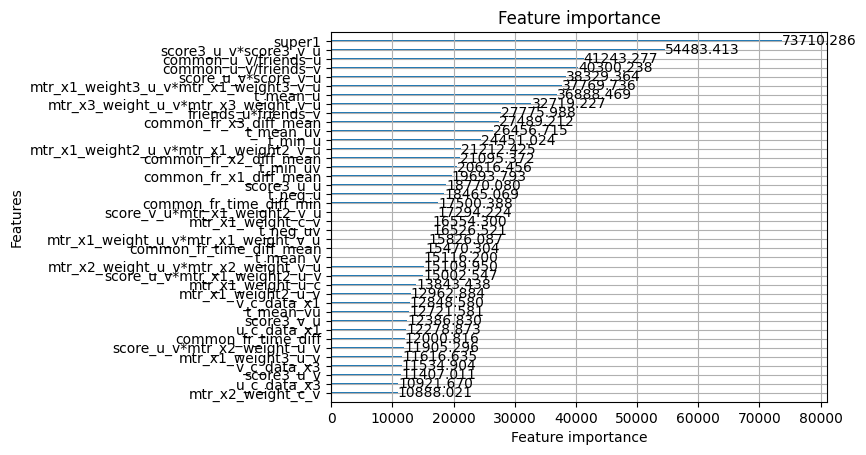

In [0]:
lgb.plot_importance(model2, max_num_features=40)

In [0]:
uv_dataset_to['pred'] = model2.predict(uv_dataset_to[columns], ntree_end=1000)
uv_dataset_to_pred = uv_dataset_to[['ego_id', 'u', 'v', 'pred']]


In [0]:
test_labels = pd.read_csv("s3://constructor-io/data-pipeline/dev/ivan_bragin/vkcup/label.csv")

def get_labels(x):
  return list(zip(x['u'], x['v']))
labels = test_labels.groupby('ego_id')[['u', 'v']].apply(lambda x: get_labels(x)).to_dict()

In [0]:
ndcgs = []
recalls = []
scores = np.asarray([[5, 4, 3, 2, 1]])
n=0
for ego_id in dataset_to.select("ego_id").distinct().toPandas().ego_id.values:
  n += 1
  ego_labels = labels[ego_id]

  ego_preds = uv_dataset_to_pred[uv_dataset_to_pred.ego_id == ego_id]

  recs = list(ego_preds.sort_values("pred", ascending=False)[['u', 'v']].values)
  if len(recs) < 5:
    recalls.append(0)
    recs += ((-1, -1),(-1, -1),(-1, -1),(-1, -1),(-1, -1))
  else:
    recalls.append(1)
  top5 = []
  for p in recs:
    p = tuple(p)
    top5.append(p)
    if len(top5) == 5:
      break
      
#   recalls.append(len([x for x in ego_labels if x in top5]) / len(ego_labels))
  true_relevance = [[int(p in ego_labels) for p in top5]]
  ndcgs.append(ndcg_score(true_relevance, scores, k=5))
  if n % 100 == 0:
    print(np.mean(ndcgs), np.mean(recalls))

0.13721221953260684 0.64
0.13274408374546431 0.66
0.13405103874758775 0.6866666666666666
0.12571745841611354 0.6775
0.12868319376841061 0.69
0.1210249227653642 0.6866666666666666
0.11875002727106107 0.68
0.12100265111799445 0.67875
0.12198520737092448 0.6733333333333333
0.12284829294547689 0.671
0.12285974324930164 0.6745454545454546
0.12744618756058745 0.6791666666666667
0.12853962974365057 0.6784615384615384
0.13148373120883525 0.6742857142857143
0.12867732858511027 0.6686666666666666
0.1284859994933189 0.665625
0.12888572394373912 0.6658823529411765
0.1275220255005963 0.6644444444444444
0.12769693478042526 0.6631578947368421
0.12479817710798659 0.664


In [0]:
cat 0.06829301738415483 0.664
0.07024935423797109 0.664
0.08775624345585556 0.664

lgmb 0.0629183211254534 0.664


ens 0.08853806839005107 0.664

  File "<command-1678643429317395>", line 1
    cat 0.06829301738415483 0.664
        ^
SyntaxError: invalid syntax


In [0]:
0.08596626682911482 0.664
0.08548672091404047 0.664
0.08820255886068976 0.664

  File "<command-2342774058799488>", line 1
    0.044559517299076284 0.5189473684210526
                         ^
SyntaxError: invalid syntax


In [0]:
test_dataset = spark.read.parquet("s3://---/ivan_bragin/vkcup/test2/")
test_pairs_recall = spark.read.parquet("s3://---/ivan_bragin/vkcup/test_preds1000_with_rank3").drop("rank")

# .select(F.col("ego_id"), F.col("u").alias("v"), F.col("v").alias("u"), F.col("label"))
uv_dataset_test = get_dataset(test_dataset, test_pairs_recall, False)
uv_dataset_test.write.parquet("s3://---/ivan_bragin/vkcup/test_dataset_1000_v7/")

In [0]:
# model = read_joblib('s3://constructor-analytics-cache/temp/ivanB/model_vkcup6')
# model_cat = read_joblib('s3://constructor-analytics-cache/temp/ivanB/model_cat_vkcup6')
# model_cat_lr = read_joblib('s3://constructor-analytics-cache/temp/ivanB/model_cat_vkcup6_lr')

model = read_joblib('s3://---/ivanB/model_last')

uv_dataset_test = pd.read_parquet("s3://---/ivan_bragin/vkcup/test_dataset_1000_v7_rev/")
with_simple_features(uv_dataset_test)


In [0]:
from tqdm import tqdm
s = len(uv_dataset_test)
for i in tqdm(range( s // 10000 + 1)):
  uv_dataset_test.loc[(i*10000):((i+1)*10000), 'pred'] = model.predict(uv_dataset_test.loc[(i*10000):((i+1)*10000), columns]) 

 24%|██▍       | 492/2028

*** WARNING: max output size exceeded, skipping output. ***

 69%|██████▊   | 1392/2028 [10:12<05:25,  1.95it/s]

In [0]:
import gc
gc.collect()

Out[11]: 421

In [0]:
uv_dataset_test[['ego_id', 'u', 'v', 'pred']].to_csv(f"s3://---/ivan_bragin/vkcup/submit_preds/model_last_rev.csv", index=False)

In [0]:
x1 = pd.read_csv(f"s3://---/ivan_bragin/vkcup/submit_preds/lgb_double_rev.csv")
x1['v1'] = x1['v']
x1['v'] = x1['u']
x1['u'] = x1['v1']
x2 = pd.read_csv(f"s3://---/ivan_bragin/vkcup/submit_preds/lgb_double.csv")



In [0]:
predicts = x2.merge(x1, on=['ego_id', 'u', 'v'])
predicts["pred"] = predicts["pred_x"] + predicts["pred_y"] 

In [0]:
predicts[['ego_id', 'u', 'v', 'pred']].to_csv(f"s3://---/ivan_bragin/vkcup/submit_preds/lgb_double_both.csv", index=False)

In [0]:
# x1['pred'] += x2['pred']
# x1

,ego_id,u,v,pred
0,1005022347595,16,31,0.003675
1,1005022347595,13,41,0.201719
2,1005022347595,16,17,0.916890
3,1005022347595,4,12,-0.921096
4,1005022347595,13,47,-1.026960
...,...,...,...,...
20275843,652835029260,91,114,-6.638361
20275844,652835029260,39,177,-4.385236
20275845,652835029260,54,74,-6.167065
20275846,652835029260,38,65,-3.604768


In [0]:
predicts = pd.read_csv(f"s3://---/ivan_bragin/vkcup/submit_preds/lgb_double_both.csv")


# predicts = x1
predicts['RN'] = predicts.sort_values("pred", ascending=False) \
             .groupby(['ego_id']) \
             .cumcount() + 1
predicts[predicts.RN <=5][['ego_id' , 'u', 'v']].to_csv(f"s3://---/ivanB/submit_lgb_double_both.csv", index=False)